In [31]:
import db_dtypes
import pandas as pd
from datetime import datetime, timedelta

from prophet import Prophet
from google.cloud import bigquery

In [33]:
dt = (datetime.today() - timedelta(days=61)).strftime('%Y-%m-%d')

client = bigquery.Client()
query = f"""
    select
        crash_date as ds,
        count(*) as y
    from `nyc-transit-426211.motor_vehicle_crashes.crashes`
    where crash_date <= '{dt}'
    group by 1
    order by 1 asc
"""

df = client.query(query).to_dataframe()
df.head()

/Users/andrew/Code/mvc/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1785: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ds,y
0,2022-01-01,283
1,2022-01-02,180
2,2022-01-03,208
3,2022-01-04,255
4,2022-01-05,306


In [34]:
print(df.shape)
df.tail()

(1060, 2)


,ds,y
1055,2024-11-21,335
1056,2024-11-22,327
1057,2024-11-23,223
1058,2024-11-24,215
1059,2024-11-25,232


In [35]:
m = Prophet()
m.fit(df)

21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future = m.make_future_dataframe(periods=1)
future.tail()

,ds
1056,2024-11-22
1057,2024-11-23
1058,2024-11-24
1059,2024-11-25
1060,2024-11-26


In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
1041,2024-11-07,251.455311,218.288303,285.361699
1042,2024-11-08,270.947722,237.217577,304.949728
1043,2024-11-09,243.636920,212.123948,277.385215
1044,2024-11-10,226.944701,194.536699,260.005370
1045,2024-11-11,239.433041,207.289398,272.516025
1046,2024-11-12,241.405118,210.015352,274.420930
1047,2024-11-13,242.123189,208.971355,276.191110
1048,2024-11-14,247.221922,214.064390,283.418674
1049,2024-11-15,267.233430,230.989748,298.625136
1050,2024-11-16,240.473624,207.935043,272.752612


In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1067,2024-12-03,240.427489,214.738745,279.841829,240.427246,240.427663,5.618845,5.618845,5.618845,-2.449474,-2.449474,-2.449474,8.068318,8.068318,8.068318,0.0,0.0,0.0,246.046334
1068,2024-12-04,240.377953,212.795969,279.151381,240.377590,240.378259,7.097020,7.097020,7.097020,-1.273247,-1.273247,-1.273247,8.370267,8.370267,8.370267,0.0,0.0,0.0,247.474973
1069,2024-12-05,240.328418,220.462333,285.374596,240.327864,240.328886,12.780287,12.780287,12.780287,4.198268,4.198268,4.198268,8.582019,8.582019,8.582019,0.0,0.0,0.0,253.108705
1070,2024-12-06,240.278882,240.574645,307.960110,240.278077,240.279560,33.182931,33.182931,33.182931,24.493166,24.493166,24.493166,8.689765,8.689765,8.689765,0.0,0.0,0.0,273.461813
1071,2024-12-07,240.229347,213.491287,279.464898,240.228402,240.230299,6.615355,6.615355,6.615355,-2.064926,-2.064926,-2.064926,8.680281,8.680281,8.680281,0.0,0.0,0.0,246.844701


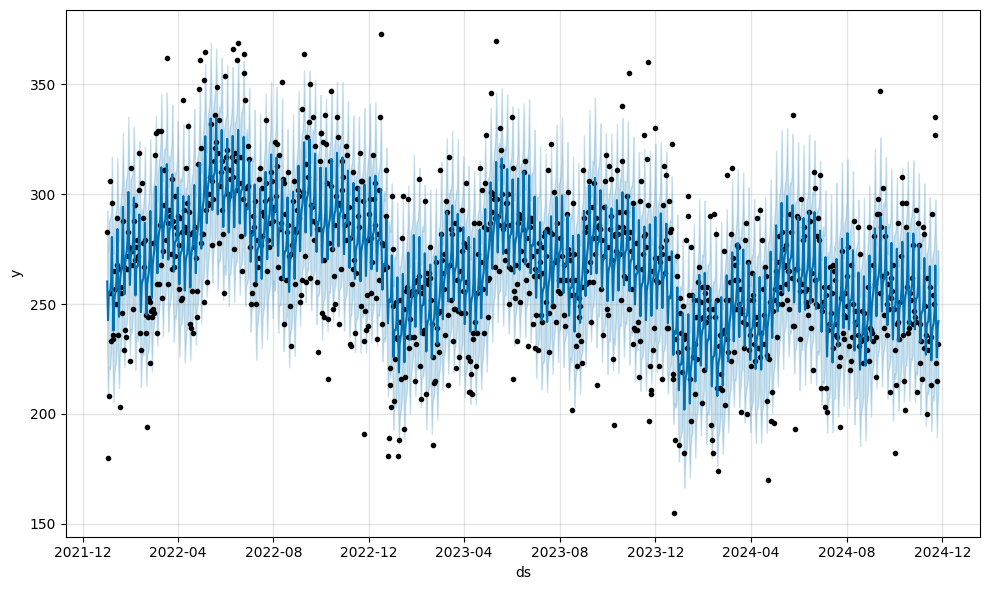

In [38]:
fig1 = m.plot(forecast)

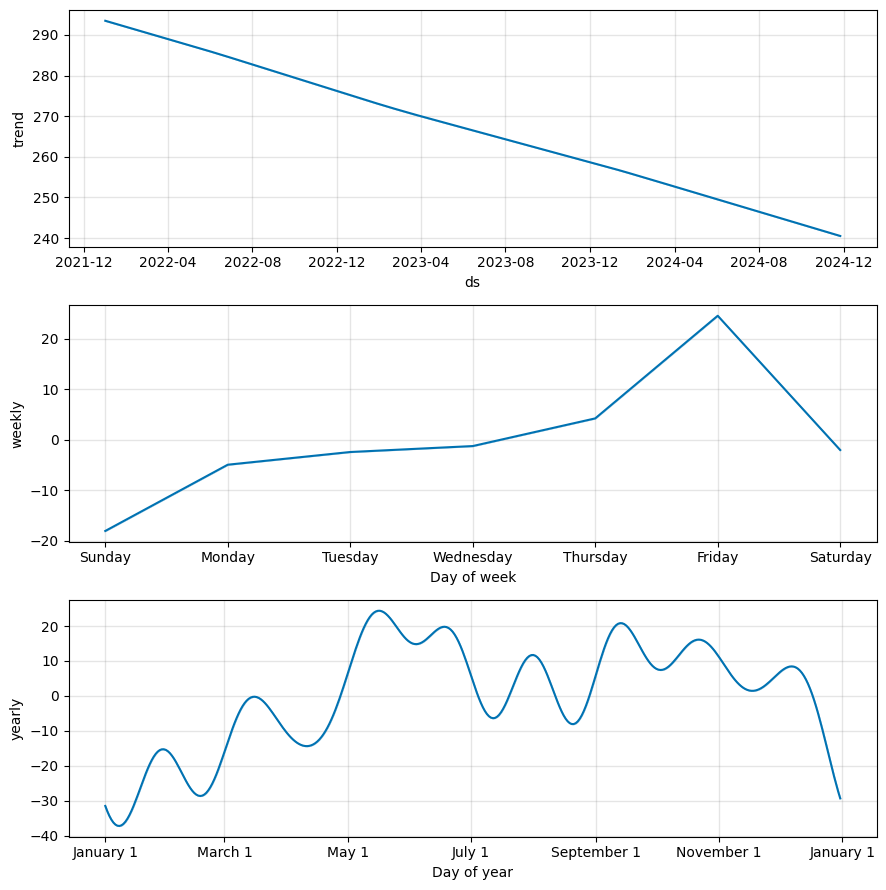

In [39]:
fig2 = m.plot_components(forecast)

#### How do predictions compare against actuals?

In [40]:
forecast['dt'] = pd.to_datetime(forecast['ds']).apply(lambda x: x.date())
pandp = forecast[['dt', 'yhat', 'yhat_lower', 'yhat_upper']].merge(df, left_on='dt', right_on='ds')
pandp['diff'] = pandp['yhat'] - pandp['y']
pandp.tail(40)

,dt,yhat,yhat_lower,yhat_upper,ds,y,diff
1020,2024-10-17,261.681120,228.807109,294.649725,2024-10-17,258,3.68112
1021,2024-10-18,282.369364,249.704068,314.843613,2024-10-18,237,45.369364
1022,2024-10-19,256.103543,222.244306,288.585665,2024-10-19,242,14.103543
1023,2024-10-20,240.288889,205.946616,274.020844,2024-10-20,239,1.288889
1024,2024-10-21,253.474419,220.612474,286.452055,2024-10-21,255,-1.525581
1025,2024-10-22,255.954042,225.233413,289.511637,2024-10-22,252,3.954042
1026,2024-10-23,256.984424,224.619704,290.488433,2024-10-23,262,-5.015576
1027,2024-10-24,262.198253,226.881721,296.910837,2024-10-24,241,21.198253
1028,2024-10-25,282.129136,246.839600,315.372030,2024-10-25,277,5.129136
1029,2024-10-26,255.097775,220.473924,289.388160,2024-10-26,247,8.097775


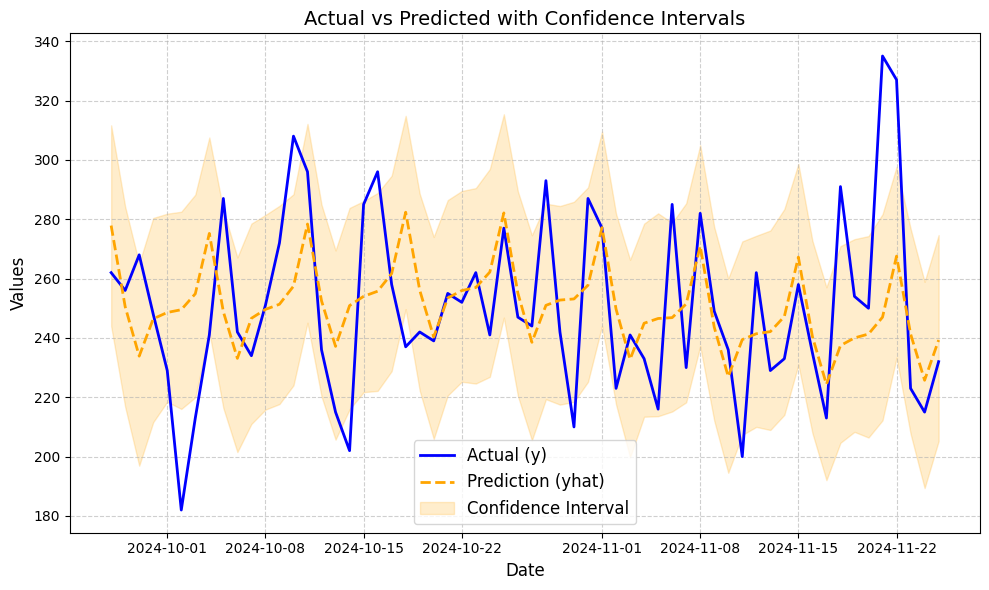

In [41]:
# plot y vs yhat
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot actual values
s1 = pandp.tail(60).reset_index()
plt.plot(s1["dt"], s1["y"], label="Actual (y)", color="blue", linewidth=2)

# Plot predictions
plt.plot(s1["dt"], s1["yhat"], label="Prediction (yhat)", color="orange", linestyle="--", linewidth=2)

# Fill confidence interval
plt.fill_between(s1["dt"], s1["yhat_lower"], s1["yhat_upper"], color="orange", alpha=0.2, label="Confidence Interval")

# Add titles and labels
plt.title("Actual vs Predicted with Confidence Intervals", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()

In [30]:
# do i wan to show something likke this? how do I iterate/day? where does mlops come in?